In [473]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

import seaborn as sn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [474]:
data = pd.read_csv("data/integrated.csv")

label = "playoff"
df = data
df['confID'].value_counts()

bins = 11  # Number of bins
# Use the cut function to perform binning
df['height'] = pd.cut(df['height'], bins=bins)
df['weight'] = pd.cut(df['weight'], bins=bins)

df.columns

Index(['year', 'tmID', 'W_team_post', 'L_team_post', 'franchID', 'confID',
       'rank', 'playoff', 'firstRound', 'semis', 'finals', 'name', 'o_fgm',
       'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb',
       'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm',
       'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb',
       'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts',
       'won_team', 'lost_team', 'GP', 'homeW', 'homeL', 'awayW', 'awayL',
       'confW', 'confL', 'min', 'attend', 'arena', 'coachID', 'stint',
       'won_coach', 'lost_coach', 'post_wins', 'post_losses', 'round',
       'series', 'tmIDWinner', 'tmIDLoser', 'W_series', 'L_series', 'playerID',
       'CBE_Sum', 'pos', 'height', 'weight', 'college', 'birthDate',
       'award_player', 'award_coach'],
      dtype='object')

In [475]:
features = df.columns
toDrop = ["rank", "semis", "finals", "firstRound"]
for col in toDrop:
    features = features.drop(col)

arr = []

for col in df.columns:

    if "post" in col.lower():
        features = features.drop(col)
        arr.append(col)

assert len(features) < len(df.columns)

X = df[features]
df = X

In [476]:
le = LabelEncoder()
y = le.fit_transform(df['playoff'])
for x in df.columns:
    df[x] = le.fit_transform(df[x])

/tmp/ipykernel_37298/817340014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = le.fit_transform(df[x])
/tmp/ipykernel_37298/817340014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = le.fit_transform(df[x])
/tmp/ipykernel_37298/817340014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [477]:
available_columns = list(features)
available_columns.remove("playoff")
key_predictors = []
features_values = pd.DataFrame(df, columns=available_columns)
target_values = df["playoff"].values
chi2_results = chi2(features_values, target_values)
best_chi2_cols = SelectKBest(chi2, k=30)

best_chi2_cols.fit(features_values, target_values)

best_chi2_features = features_values.columns[best_chi2_cols.get_support()]

for k in (best_chi2_features):
    key_predictors.append(k)

key_predictors.append("playoff")
key_predictors.append("year")
key_predictors.append("confID")
df = df[key_predictors]
corr_matrix = df.corr()
#fig = plt.figure(figsize=(36,36), dpi = 480)
#sn.heatmap(df.corr(), annot = True, fmt = '.2f')
#plt.show()
print(len(df.columns))

33


In [478]:
high_correlation_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.91:
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            correlation_value = corr_matrix.iloc[i, j]
            high_correlation_pairs.append((feature1, feature2, correlation_value))

# Print the high-correlation pairs
for feature1, feature2, correlation_value in high_correlation_pairs:
    print(f"Features: {feature1} and {feature2} have a correlation of {correlation_value:.2f}")
    if feature2 in key_predictors:
        key_predictors.remove(feature2)

df = df[key_predictors]



Features: o_fta and o_ftm have a correlation of 0.94
Features: o_reb and o_dreb have a correlation of 0.93
Features: o_pts and o_fgm have a correlation of 0.96
Features: lost_team and won_team have a correlation of -0.99
Features: awayL and awayW have a correlation of -0.99
Features: confL and confW have a correlation of -0.94


In [479]:
print(df.columns)

Index(['o_fga', 'o_fta', 'o_oreb', 'o_reb', 'o_asts', 'o_blk', 'o_pts',
       'd_fga', 'd_3pa', 'd_oreb', 'd_reb', 'd_asts', 'd_pf', 'lost_team',
       'homeL', 'awayL', 'confL', 'attend', 'won_coach', 'tmIDWinner',
       'tmIDLoser', 'W_series', 'CBE_Sum', 'birthDate', 'playoff', 'year',
       'confID'],
      dtype='object')


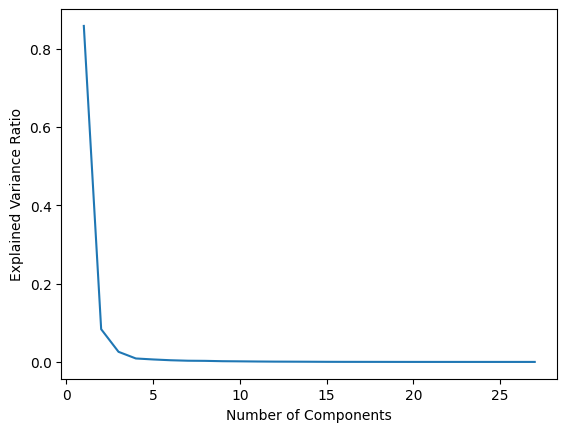

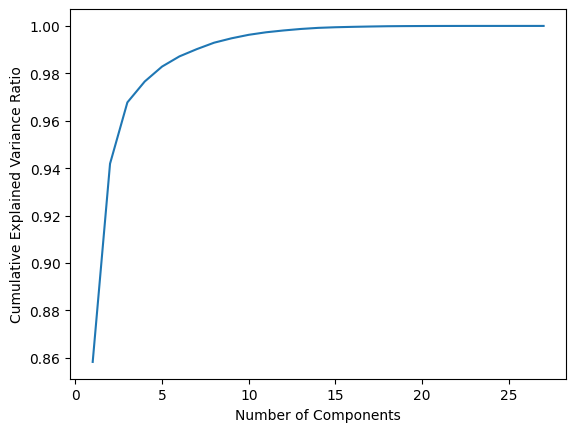

In [480]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(df)  # X is your data
explained_var_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

cum_var_ratio = np.cumsum(explained_var_ratio)
plt.plot(range(1, len(cum_var_ratio) + 1), cum_var_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()


In [481]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


n_components = 10
columns_to_keep = ['year', 'confID', label]
df_to_keep = df[columns_to_keep]

df.drop(columns_to_keep, axis=1, inplace=True)

custom_column_names = [f'PC{i + 1}' for i in range(n_components)]  # Create custom column names

# Assuming 'X' is your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA(n_components=n_components)  # Choose the number of components you want
X_pca = pca.fit_transform(X_scaled)

df_result = pd.DataFrame(data=X_pca, columns=custom_column_names)
df = pd.concat([df_result, df_to_keep], axis=1)

print(df)

# X_pca now contains the reduced-dimensional representation of your data


           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     0.029386  5.804112 -0.217418  0.600483  2.014016  1.621245 -1.292085   
1    -2.162123  0.169439  0.065804  2.795834  0.495595 -0.877768 -0.964747   
2    -2.162123  0.169439  0.065804  2.795834  0.495595 -0.877768 -0.964747   
3     0.568703  1.042471  0.002792  1.827562  1.536456 -0.438997 -0.188129   
4    -3.855082 -0.541065 -0.278417  1.389556  1.296991  0.167867  0.798398   
...        ...       ...       ...       ...       ...       ...       ...   
2014 -1.528546  3.659855 -0.323779 -0.892695 -2.001923 -0.254372 -1.439838   
2015  0.550758  3.578552  2.197234 -1.403783  1.064306 -0.620002 -0.509340   
2016 -1.341446  4.038518 -0.356695 -0.806793 -1.750554 -0.284877 -1.280424   
2017 -1.523845  3.650495 -0.323359 -0.872085 -1.986131 -0.245662 -1.441765   
2018  0.654650  3.609744  1.923612 -2.225948  0.122015 -1.440373 -0.310650   

           PC8       PC9      PC10  year  confID  playoff  
0  

In [482]:
print(df.columns)

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'year', 'confID', 'playoff'],
      dtype='object')


In [483]:
# corr_matrix = df.corr()
# fig = plt.figure(figsize=(30,30), dpi = 480)
# sn.heatmap(df.corr(), annot = True, fmt = '.2f')
# plt.show()

In [484]:
clf = DecisionTreeClassifier()
mlp = MLPClassifier()

In [485]:
def split_data(df):
    return df[df['confID'] == 0], df[df['confID'] == 1]

In [486]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

def confusion_matrix_plot(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        xticklabels=['No', 'Yes'],
        yticklabels=['No', 'Yes']
    )
    plt.ylabel("Prediction", fontsize=13)
    plt.xlabel("Actual", fontsize=13)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()
    
def roc_curve_plot(y_test, y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.plot('False Positive Rate')
    plt.plot('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    

def model_score(y_test, y_pred, y_prob):
    confusion_matrix_plot(y_test, y_pred)
    roc_curve_plot(y_test, y_prob)
    print("AUC: ", roc_auc_score(y_test, y_prob))
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("F1: ", f1_score(y_test, y_pred))

/tmp/ipykernel_37298/1166964656.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.drop(['confID'], axis=1, inplace=True)
/tmp/ipykernel_37298/1166964656.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop(['confID'], axis=1, inplace=True)
/tmp/ipykernel_37298/1166964656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sampleWeight'] = data['year'].ap

/tmp/ipykernel_37298/1166964656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sampleWeight'] = data['year'].apply(lambda year_x: 2 ** (year - year_x - 1) if year > year_x else 1)
/tmp/ipykernel_37298/1166964656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sampleWeight'] = data['year'].apply(lambda year_x: 2 ** (year - year_x - 1) if year > year_x else 1)
/tmp/ipykernel_37298/1166964656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


[[ 32  51]
 [ 28 145]]


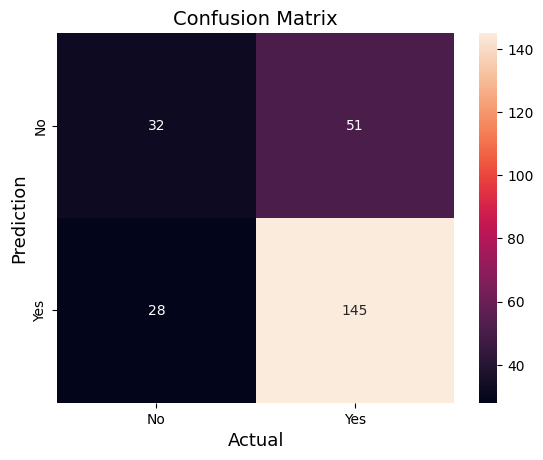

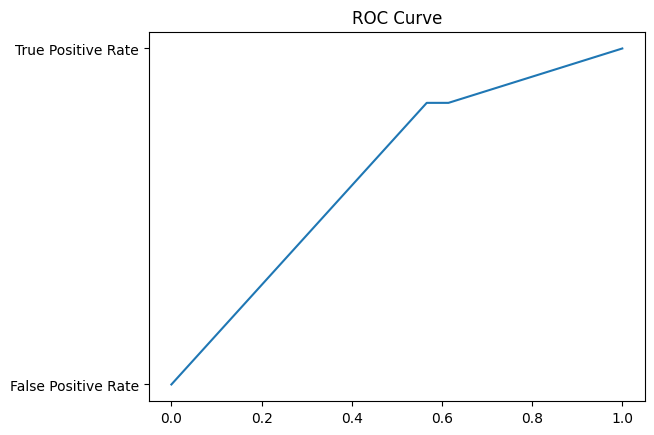

AUC:  0.6320426213524618
Accuracy:  0.69140625
Precision:  0.7397959183673469
Recall:  0.838150289017341
F1:  0.7859078590785907


([1, 2, 3, 4, 5, 6, 7, 8],
 [0.6535433070866141,
  0.5204081632653061,
  0.648,
  0.7475728155339806,
  0.6666666666666666,
  0.616822429906542,
  0.7467248908296943,
  0.69140625])

In [487]:
def train_model_validation(year, model, data, label, param_grid):
    data['sampleWeight'] = data['year'].apply(lambda year_x: 2 ** (year - year_x - 1) if year > year_x else 1)
    train_data = data[data["year"] < year]
    test_data = data[data["year"] == year]

    X_train, X_val, y_train, y_val = train_test_split(train_data.drop([label], axis=1),
                                                      train_data[label], test_size=0.3)

    X_test, y_test = test_data.drop([label, 'sampleWeight'], axis=1), test_data[label]
    sample_weight = X_train['sampleWeight']
    model.fit(X_train.drop(['sampleWeight'], axis=1), y_train, sample_weight=sample_weight)
    grid_search = GridSearchCV(model, param_grid, cv=None)
    grid_search.fit(X_val, y_val)

    sample_weight = train_data["sampleWeight"]
    model.set_params(**grid_search.best_params_)

    model.fit(train_data.drop([label, "sampleWeight"], axis=1), train_data[label], sample_weight=sample_weight)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    return y_test, y_pred, y_prob


#def train_model(year, model, data, label):
#    data['sampleWeight'] = data['year'].apply(lambda year_x: 2 ** (year - year_x - 1) if year > year_x else 1)
#    train_data = data[data["year"] < year]
#    test_data = data[data["year"] == year]
#
#    X_train, X_test = train_data.drop([label, 'sampleWeight'], axis=1), test_data.drop([label, 'sampleWeight'], axis=1)
#    y_train, y_test = train_data[label], test_data[label]
#    sample_weight = train_data['sampleWeight']
#
#    model.fit(X_train, y_train, sample_weight=sample_weight)
#    y_pred = model.predict(X_test)
#    y_prob = model.predict_proba(X_test)
#
#    return y_test, y_pred, y_prob


def train_evaluate_decision_tree_graph(model, data):
    accuracy_scores = []
    years_tested = []

    data = data.sort_values(by="year")
    data1, data2 = df[df['confID'] == 0], df[df['confID'] == 1]

    data1.drop(['confID'], axis=1, inplace=True)
    data2.drop(['confID'], axis=1, inplace=True)
    years = sorted(data["year"].unique())
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    # escolher o segundo
    for year in years[1:]:
        y_test1, y_pred1, y_prob1 = train_model_validation(year, model, data1, label, param_grid)
        y_test2, y_pred2, y_prob2 = train_model_validation(year, model, data2, label, param_grid)

        y_test = np.concatenate((y_test1, y_test2))
        y_pred = np.concatenate((y_pred1, y_pred2))
        y_prob = np.concatenate((y_prob1[:, 1], y_prob2[:, 1]))

        if year == years[-1]:
            model_score(y_test, y_pred, y_prob)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        years_tested.append(year)

    return years_tested, accuracy_scores


train_evaluate_decision_tree_graph(clf, df)

 Model Score